# Smart Queue Monitoring System - Manufacturing Scenario

In this project, you will build a people counter app to reduce congestion in queuing systems by guiding people to the least congested queue. You will have to use Intel's OpenVINO API and the person detection model from their open model zoo to build this project. It demonstrates how to create a smart video IoT solution using Intel® hardware and software tools. This solution detects people in a designated area, providing the number of people in the frame.

## Overview of how it works
Your code should read the equivalent of command line arguments and loads a network and image from the video input to the Inference Engine (IE) plugin. A job is submitted to an edge compute node with a hardware accelerator such as Intel® HD Graphics GPU, Intel® Movidius™ Neural Compute Stick 2 and Intel® Arria® 10 FPGA.
After the inference is completed, the output videos are appropriately stored in the /results/[device] directory, which can then be viewed within the Jupyter Notebook instance.

## Demonstration objectives
* Video as input is supported using **OpenCV**
* Inference performed on edge hardware (rather than on the development node hosting this Jupyter notebook)
* **OpenCV** provides the bounding boxes, labels and other information
* Visualization of the resulting bounding boxes


## Step 0: Set Up

### 0.1: Import dependencies

Run the below cell to import Python dependencies needed for displaying the results in this notebook
(tip: select the cell and use **Ctrl+enter** to run the cell)

In [3]:
#Import your dependencies here
# !pip3 install matplotlib
from demoTools.demoutils import *
import matplotlib.pyplot as plt

### 0.2  (Optional-step): Original video without inference

If you are curious to see the input video, run the following cell to view the original video stream used for inference and people counter.

In [45]:
videoHTML('People Counter Video', ['./resources/manufacturing.mp4'])

## Step 1: Using Intel® Distribution of OpenVINO™ toolkit

We will be using Intel® Distribution of OpenVINO™ toolkit Inference Engine (IE) to locate people in frame.
There are five steps involved in this task:

1. Download the model using the open_model_zoo
2. Choose a device and create IEPlugin for the device
3. Read the Model using IENetwork
4. Load the IENetwork into the Plugin
5. Run inference.

### 1.1 Downloading Model

Write a command to download the  **person-detection-retail-0013** model in an IR format

In [9]:
## Write your command here
!python3 /opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name person-detection-retail-0013 

################|| Downloading models ||################

========== Downloading /home/u39058/smart_queue_system/starter_files/intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml
... 100%, 345 KB, 4913 KB/s, 0 seconds passed

========== Downloading /home/u39058/smart_queue_system/starter_files/intel/person-detection-retail-0013/FP32/person-detection-retail-0013.bin
... 100%, 2823 KB, 29712 KB/s, 0 seconds passed

========== Downloading /home/u39058/smart_queue_system/starter_files/intel/person-detection-retail-0013/FP16/person-detection-retail-0013.xml
... 100%, 345 KB, 12281 KB/s, 0 seconds passed

========== Downloading /home/u39058/smart_queue_system/starter_files/intel/person-detection-retail-0013/FP16/person-detection-retail-0013.bin
... 100%, 1411 KB, 30547 KB/s, 0 seconds passed

========== Downloading /home/u39058/smart_queue_system/starter_files/intel/person-detection-retail-0013/FP32-INT8/person-detection-retail-0013.xml
... 100%, 909 KB, 10558 KB/s, 0 se

## Step 2 : Inference on a video

By now you should have already completed the inference code in <a href="person_detect.py">person_detect.py</a>. If you haven't done so already, then you should do it now.

The Python code should take in command line arguments for video, model etc.

While the type of command line options is up to you, the command below is an example 

```
python3 main.py -m ${MODELPATH} \
                -i ${INPUT_FILE} \
                -o ${OUTPUT_FILE} \
                -d ${DEVICE} \
                -pt ${THRESHOLD}\

```

##### The description of the arguments used in the argument parser is the command line executable equivalent.
* -m location of the pre-trained IR model which has been pre-processed using the model optimizer. There is automated support built in this argument to support both FP32 and FP16 models targeting different hardware
* -i  location of the input video stream
* -o location where the output file with inference needs to be stored (results/[device])
* -d type of Hardware Acceleration (CPU, GPU, MYRIAD, HDDL or HETERO:FPGA,CPU)
* -pt probability threshold value for the person detection

### 2.1 Creating job file

To run inference on the video, we need more compute power.
We will run the workload on several edge compute nodes present in the IoT DevCloud. We will send work to the edge compute nodes by submitting the corresponding non-interactive jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

The job file is written in Bash, and will be executed directly on the edge compute node.
You will have to create the job file by running the cell below.

In [10]:
%%writefile person_detect_job.sh
# The writefile magic command can be used to create and save a file

MODEL=$1
DEVICE=$2
VIDEO=$3
QUEUE=$4
OUTPUT=$5
PEOPLE=$6

mkdir -p $5

if [ $DEVICE = "HETERO:FPGA,CPU" ]; then
    #Environment variables and compilation for edge compute nodes with FPGAs
    source /opt/intel/init_openvino.sh
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_sg1_bitstreams/2019R4_PL1_FP16_MobileNet_Clamp.aocx
fi

python3 person_detect.py  --model ${MODEL} \
                                --visualise \
                                --queue_param ${QUEUE} \
                                --device ${DEVICE} \
                                --video ${VIDEO}\
                                --output_path ${OUTPUT}\
                                --max_people ${PEOPLE} \

Writing person_detect_job.sh


### 2.2 Understand how jobs are submitted into the queue

Now that we have the job script, we can submit the jobs to edge compute nodes. In the IoT DevCloud, you can do this using the `qsub` command.
We can submit people_counter to several different types of edge compute nodes simultaneously or just one node at a time.

There are three options of `qsub` command that we use for this:
- `-l` : this option let us select the number and the type of nodes using `nodes={node_count}:{property}`. 
- `-F` : this option let us send arguments to the bash script. 
- `-N` : this option let us name the job so that it is easier to distinguish between them.

Example using `qsub` command:

`!qsub person_detect_job.sh -l nodes=1:tank-870:i5-6500te -d . -F "models/intel/PATH-TO-MODEL DEVICE resources/manufacturing.mp4 bin/queue_param/manufacturing.npy results/manufacturing/DEVICE MAX-PEOPLE" -N JOB-NAME`

You will need to change the following variables, `models/intel/PATH-TO-MODEL`, `DEVICE`, `results/manufacturing/DEVICE`, `MAX-PEOPLE`, and `JOB-NAME` to the appropriate values.

If you are curious to see the available types of nodes on the IoT DevCloud, run the following optional cell.

In [3]:
!pbsnodes | grep compnode | awk '{print $3}' | sort | uniq -c

     43 idc001skl,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe
     13 idc002mx8,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-r,iei-mustang-v100-mx8
     17 idc003a10,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,hddl-f,iei-mustang-f100-a10
     22 idc004nc2,compnode,iei,tank-870,intel-core,i5-6500te,skylake,intel-hd-530,ram8gb,net1gbe,ncs,intel-ncs2
      8 idc006kbl,compnode,iei,tank-870,intel-core,i5-7500t,kaby-lake,intel-hd-630,ram8gb,net1gbe
     12 idc007xv5,compnode,iei,tank-870,intel-xeon,e3-1268l-v5,skylake,intel-hd-p530,ram32gb,net1gbe
     14 idc008u2g,compnode,up-squared,grove,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,net1gbe,ncs,intel-ncs2
      1 idc009jkl,compnode,jwip,intel-core,i5-7500,kaby-lake,intel-hd-630,ram8gb,net1gbe
      1 idc010jal,compnode,jwip,intel-atom,e3950,apollo-lake,intel-hd-505,ram4gb,net1gbe
      1 idc011ark2250s,compnode,advantech,intel-

Here, the properties describe the node, and number on the left is the number of available nodes of that architecture.

### 2.3 Job queue submission

Each of the cells below should submit a job to different edge compute nodes.
The output of the cell is the `JobID` of your job, which you can use to track progress of a job.

**Note** You can submit all jobs at once or one at a time. 

After submission, they will go into a queue and run as soon as the requested compute resources become available. 
(tip: **shift+enter** will run the cell and automatically move you to the next cell. So you can hit **shift+enter** multiple times to quickly run multiple cells)

If your job successfully runs and completes, it will output a video, `output_video.mp4`, and a text file, `stats.txt`, in the `results/retail/DEVICE` folder.

#### Submitting to an edge compute node with an Intel® CPU
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload will run on the CPU.

In [37]:
#Submit job to the queue



job_id = !qsub person_detect_job.sh -l nodes=1:tank-870:i5-6500te -d . -F "intel/person-detection-retail-0013/FP16/person-detection-retail-0013 CPU resources/manufacturing.mp4 bin/queue_param/manufacturing.npy results/manufacture/CPU 5" -N job_cpu_manufacture_1

print(job_id[0])

29161.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® Core CPU and using the onboard Intel® GPU
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core i5-6500TE</a>. The inference workload will run on the Intel® HD Graphics 530 card integrated with the CPU.

In [38]:
#Submit job to the queue
job_id = !qsub person_detect_job.sh -l nodes=1:tank-870:i5-6500te:intel-hd-530 -d . -F "intel/person-detection-retail-0013/FP16/person-detection-retail-0013 HETERO:GPU,CPU resources/manufacturing.mp4 bin/queue_param/manufacturing.npy results/manufacture/GPU 5" -N job_gpu_manufacture

print(job_id[0])

29162.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with Intel® NCS 2 (Neural Compute Stick 2)
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload will run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [12]:
#Submit job to the queue
job_id = !qsub person_detect_job.sh -l nodes=idc004nc2:tank-870:i5-6500te:intel-ncs2 -d . -F "intel/person-detection-retail-0013/FP16/person-detection-retail-0013 MYRIAD resources/manufacturing.mp4 bin/queue_param/manufacturing.npy results/manufacture/MYRIAD 5" -N job_myriad_manufacture

print(job_id[0])

29142.v-qsvr-1.devcloud-edge


#### Submitting to an edge compute node with IEI Mustang-F100-A10 (Intel® Arria® 10 FPGA)
In the cell below, write a script to submit a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core™ i5-6500te CPU</a> . The inference workload will run on the <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> card installed in this node.

In [39]:
#Submit job to the queue
job_id = !qsub person_detect_job.sh -l nodes=1:tank-870:i5-6500te:iei-mustang-f100-a10 -d . -F "intel/person-detection-retail-0013/FP16/person-detection-retail-0013 HETERO:FPGA,CPU resources/manufacturing.mp4 bin/queue_param/manufacturing.npy results/manufacture/Mustang 5" -N job_fpga_manufacture

print(job_id[0])

29163.v-qsvr-1.devcloud-edge


### 2.4 Check if the jobs are done

To check on the jobs that were submitted, use a command to check the status of the job.

Column `S` shows the state of your running jobs.

For example:
- If `JOB ID`is in Q state, it is in the queue waiting for available resources.
- If `JOB ID` is in R state, it is running.

In [43]:
# Enter your command here to check the status of your jobs


liveQstat()

Output(layout=Layout(border='1px solid gray', height='300px', width='100%'))

Button(description='Stop', style=ButtonStyle())

***Wait!***

Please wait for the inference jobs and video rendering to complete before proceeding to the next step.

## Step 3: View Results

Write a short utility script that will display these videos within the notebook.

*Tip*: See `demoutils.py` if you are interested in understanding further on how the results are displayed in notebook.

In [4]:
#Write your script for Intel Core CPU video results here

# If video is not playing, you can download and watch it.


videoHTML("CPU", ['results/manufacture/CPU/output_video.mp4'])


In [5]:
#Write your script for Intel Core CPU video results here

# If video is not playing, you can download and watch it.


videoHTML("GPU", ['results/manufacture/GPU/output_video.mp4'])


In [ ]:
#Write your script for Intel CPU + Intel NCS2 video results here
# videoHTML('Peopl Video', ['results/manufacture/My/output_video.mp4'])

In [6]:
#Write your script for Intel® Arria® 10 FPGA video results here

videoHTML("FPGA Manufacturing", ['results/manufacture/Mustang/output_video.mp4'])

## Step 4: Assess Performance

This is where you need to write code to asses how well your model is performing. You will use the `stats.txt` file located in your results directory.
You need to compare the following timings for all the models across all 4 devices:

- Model loading time
- Average Inference Time
- FPS

Show your results in the form of a bar chart using matplotlib

In [7]:

import json
data = []
import os
for root, dirs, files in os.walk("results/manufacture/", topdown=False):
    for name in files:
        if name == "stats.txt":
            path = os.path.join(root, name)
            with open(path,'r') as f:
                data.append(json.loads(f.read()))

                
# Model loading time is last line of stats.txt
label = []
model_loading_time = []
avg_infer_time = []
fps = []
for i in data:
    label.append(i['device_type'])
    model_loading_time.append(i['model_loading_time'])
    avg_infer_time.append(i['model_avg_infer_time'])
    fps.append(1/i['model_avg_infer_time'])

Text(0.5, 1.0, 'Model Inference time')

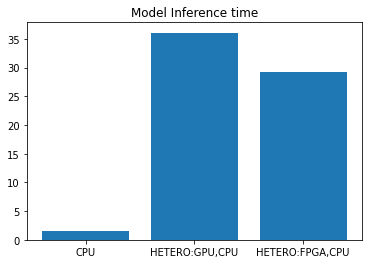

In [17]:
#TODO Write your code here for model loading time on all 4 device types

plt.bar(label, model_loading_time)
plt.title("Model Inference time")

Text(0.5, 1.0, 'Average Inference Time')

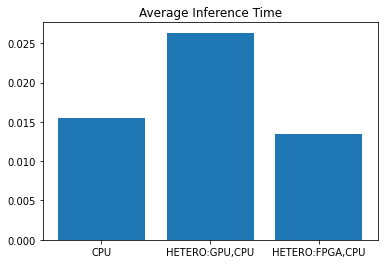

In [16]:
#TODO Write your code here for model average inference time on all 4 device types

plt.bar(label, avg_infer_time)
plt.title("Average Inference Time")

Text(0.5, 1.0, 'FPS')

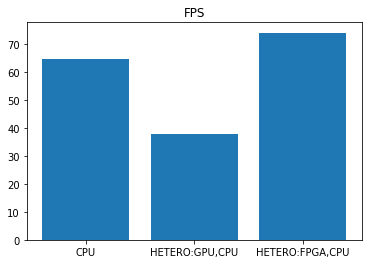

In [18]:
#TODO Write your code here for model FPS on all 4 device types
plt.bar(label, fps)
plt.title("FPS")
